# ANÁLISIS DE BIWENGER

Este código obtiene los datos de los jugadores de la web de Biwenger y analiza los jugadores por rango de precio, las posibilidades de obtener a un jugador de un rango de precio determinado en un sobre, y el porcentaje de titularidad de los jugadores desde la web FutbolFantasy

## Obtención de los datos de Biwenger

In [45]:
import requests
import csv
import pandas as pd

#Obtenemos el Json de Biwenger

r = requests.get(
    "https://cf.biwenger.com/api/v2/competitions/la-liga/data?lang=en&score=1").json()

#Extraemos los datos de los jugadores

data = []
for k, v in r['data']['players'].items():
    data.append(v)

with open('output.csv', 'w', newline="", encoding="UTF-8") as f:
    writer = csv.writer(f)
    writer.writerow(v.keys())
    writer.writerows(data)

In [2]:
df = pd.DataFrame(data)

In [3]:
df

,id,name,slug,teamID,position,price,fantasyPrice,status,priceIncrement,playedHome,playedAway,fitness,points,pointsHome,pointsAway,pointsLastSeason,statusInfo
0,12215,Alejandro Cantero,a-cantero,10.0,4,270000,7000000,ok,0,6,5,"[2, 2, 2, None, 2]",20,6,14,NaN,NaN
1,17731,Catena,a-catena,70.0,2,4120000,11000000,ok,10000,6,7,"[2, 6, 6, 6, 2]",58,32,26,NaN,NaN
2,16606,Aitor Fernández,a-fernandez,10.0,1,2330000,20000000,ok,-40000,5,4,"[None, 6, 2, 2, 2]",36,12,24,118.0,NaN
3,15462,Gorosabel,a-gorosabel,13.0,2,2260000,15000000,ok,-30000,6,4,"[None, 2, None, 2, 2]",32,16,16,128.0,NaN
4,2224,Antonio Sánchez,a-sanchez,465.0,3,300000,8000000,ok,0,2,3,"[2, 2, 10, 2, None]",14,12,2,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
532,1074,Yuri,yuri-berchiche,1.0,2,640000,18000000,injured,0,0,0,"[injured, injured, injured, injured, injured]",0,0,0,81.0,Operación por una pubalgia.
533,23041,Demir,yusuf-demir,3.0,3,420000,7000000,ok,0,2,3,"[None, None, 2, None, None]",6,4,2,NaN,NaN
534,1800,Zaldua,zaldua,13.0,2,520000,12000000,ok,20000,3,6,"[2, None, 2, 2, 2]",14,4,10,30.0,NaN
535,8376,Zubeldia,zubeldia,13.0,3,560000,18000000,doubt,-10000,3,4,"[None, 2, 2, 2, 0]",14,8,6,92.0,Pubis problems


## Cálculo del número de jugadores en un rango de precios

In [4]:
n_players = df['price'].count()

In [5]:
precios = list(df['price'])

In [6]:
def rango_precios(a,b,precios):
    count = 0
    for i in range (len(precios)):
        if precios[i]>=a and precios[i]<=b:
            count = count + 1
    porcentaje = (count/len(precios))*100
    return (count, porcentaje)
    

In [7]:
porcentaje = rango_precios(150000,500000,precios)[1]
print('El porcentaje de jugadores en el intervalo es de :', porcentaje, '%')

El porcentaje de jugadores en el intervalo es de : 31.28491620111732 %


## Histograma del número de jugadores por un precio

Text(0, 0.5, 'Jugadores')

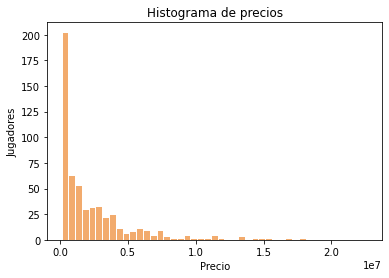

In [8]:
import matplotlib.pyplot as mp
intervalos = range(min(precios),max(precios),500000)
mp.hist(x=precios, bins=intervalos, color='#F2AB6D', rwidth=0.85)
mp.title('Histograma de precios')
mp.xlabel('Precio')
mp.ylabel('Jugadores')

## TOP 10 Jugadores con mayor subida de valor

In [9]:
delta_max=[]
player_delta=[]
for i in range (len(df['priceIncrement'])):
    if df['priceIncrement'][i]>=80000:
        delta_max.append(df['priceIncrement'][i])
        player_delta.append(df['name'][i])
        
price_var = dict(zip(player_delta,delta_max))

In [10]:
import operator
price_var = sorted(price_var.items(), key=operator.itemgetter(1))
price_var

[('Elustondo', 80000),
 ('Silva', 80000),
 ('Hugo Duro', 80000),
 ('Sergi Gómez', 80000),
 ('Danjuma', 90000),
 ('Gayà', 90000),
 ('Guedes', 90000),
 ('Nico González', 90000),
 ('Montiel', 100000),
 ('Iago Aspas', 100000),
 ('Isak', 110000),
 ('Kroos', 110000),
 ('Maffeo', 110000),
 ('Mikel Merino', 110000),
 ('Oyarzabal', 110000),
 ('Diego López', 120000),
 ('Griezmann', 130000),
 ('Álvaro García', 140000),
 ('Joselu', 140000),
 ('Vinícius Jr', 140000),
 ('De Tomás', 150000),
 ('Lucas Boyé', 200000),
 ('Xavi Hernández', 240000)]

## CÁLCULO PROBABILIDADES SOBRES

 Estos códigos calculan la probabilidad de obtener un jugador de un rango de precio determinado al comprar los diferentes tipos de sobres. PSe obtiene el vector probabilidad teniendo solo en cuenta los jugadores en el rango del sobre.

## Probabilidades de un Sobre Bronce

In [11]:
probability = []
rango = []
n=0
p=0
bronze_players = rango_precios(0,5000000,precios)[0]
for i in range (1000000,5000001,1000000):
    z = str(i-1e6) + ' - ' + str(i)
    rango.append(z)
    n = rango_precios(i-1000000,i,precios)[0]
    p = (n/bronze_players)*100
    probability.append(p)

probabilidad = dict(zip(rango,probability))

keys = []
values = []
for key,value in probabilidad.items():
    keys.append(str(key))
    values.append(str(value))

s= dict(zip(keys,values))
d = pd.DataFrame(s, index = ['Probabilidad (%)'])
d

,0.0 - 1000000,1000000.0 - 2000000,2000000.0 - 3000000,3000000.0 - 4000000,4000000.0 - 5000000
Probabilidad (%),53.104925053533194,19.271948608137045,13.704496788008566,9.421841541755889,4.710920770877944


## Probabilidades de un Sobre Plata

In [12]:
probability = []
rango = []
n=0
p=0
silver_players = rango_precios(5000000,10000000,precios)[0]
for i in range (6000000,10000001,1000000):
    z = str(i-1e6) + ' - ' + str(i)
    rango.append(z)
    n = rango_precios(i-1000000,i,precios)[0]
    p = (n/silver_players)*100
    probability.append(p)
    
invest_recover = probability[3]+probability[4]
print ('Las posibilidades de ganar dinero con el sobre son de: ',invest_recover)
probabilidad = dict(zip(rango,probability))

keys = []
values = []
for key,value in probabilidad.items():
    keys.append(str(key))
    values.append(str(value))

s= dict(zip(keys,values))
d = pd.DataFrame(s, index = ['Probabilidad (%)'])
d

Las posibilidades de ganar dinero con el sobre son de:  12.962962962962962


,5000000.0 - 6000000,6000000.0 - 7000000,7000000.0 - 8000000,8000000.0 - 9000000,9000000.0 - 10000000
Probabilidad (%),37.03703703703704,27.77777777777778,22.22222222222222,3.7037037037037033,9.25925925925926


In [13]:
probability

[37.03703703703704,
 27.77777777777778,
 22.22222222222222,
 3.7037037037037033,
 9.25925925925926]

## Probabilidades Sobre Oro

In [14]:
probability = []
n=0
p=0
gold_players = rango_precios(10000000,30000000,precios)[0]
for i in range (10000000,30000001,1000000):
    z = str(i-1e6) + ' - ' + str(i)
    rango.append(z)
    n = rango_precios(i-1000000,i,precios)[0]
    p = (n/gold_players)*100
    probability.append(p)

probabilidad = dict(zip(rango,probability))

keys = []
values = []
for key,value in probabilidad.items():
    keys.append(str(key))
    values.append(str(value))

s= dict(zip(keys,values))
d = pd.DataFrame(s, index = ['Probabilidad (%)'])
d

,5000000.0 - 6000000,6000000.0 - 7000000,7000000.0 - 8000000,8000000.0 - 9000000,9000000.0 - 10000000,10000000.0 - 11000000,11000000.0 - 12000000,12000000.0 - 13000000,13000000.0 - 14000000,14000000.0 - 15000000,15000000.0 - 16000000,16000000.0 - 17000000,17000000.0 - 18000000,18000000.0 - 19000000,19000000.0 - 20000000,20000000.0 - 21000000,21000000.0 - 22000000,22000000.0 - 23000000,23000000.0 - 24000000,24000000.0 - 25000000
Probabilidad (%),31.25,12.5,25.0,6.25,12.5,6.25,6.25,6.25,0.0,0.0,0.0,0.0,6.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## BUSCAR JUGADORES TITULARES

In [2]:
from bs4 import BeautifulSoup
import urllib
import re

url = 'https://www.futbolfantasy.com/'
html = urllib.request.urlopen(url)
soup = BeautifulSoup(html)
teams = soup('a',class_ ='team')
Equipos = []
for team in teams:
    alt = team.get('alt')
    if alt not in Equipos:
        Equipos.append(alt)

### START THE CRAWLER ###

links=[]
for team in teams:
    link = team.get('href')
    if link not in links:
        links.append(link)


titulares_equipos=[]
for url2 in links:
    html2 = urllib.request.urlopen(url2)
    soup2 = BeautifulSoup(html2)
    equipo = soup2('span', class_='nombre')
    equipo = re.findall('(?<=>).*(?=<)',str(equipo))
    jug = soup2('a', class_='juggador')
    datos_jug=[]
    for i in jug:
        datos_jug.append(i.contents)
        p = re.findall('\d\d%',str(i.contents))
        n = re.findall('(?<=>).*(?=<)',str(i.contents))
        nombres_titulares = []
        for nombres in titulares_equipos:
            nombres_titulares.append(nombres[0])
        if len(n)>0:
            if n[0] not in nombres_titulares:
                if p != []:
                    z = [n[0],p[0],equipo[0]]
                    titulares_equipos.append(z)

In [16]:
df_ff = pd.DataFrame(titulares_equipos,columns=['name','Titularidad','Equipo'])
df_ff

,name,Titularidad,Equipo
0,Pacheco,95%,Alavés
1,Lejeune,60%,Alavés
2,Miazga,40%,Alavés
3,Loum,80%,Alavés
4,Pina,20%,Alavés
...,...,...,...
422,Trigueros,60%,Villarreal
423,Coquelin,40%,Villarreal
424,Rubén Peña,10%,Villarreal
425,Moi Gómez,30%,Villarreal


In [17]:
#Sacamos los titulares de un equipo, por ejemplo el Alavés:
def titularidad_equipo(equipo):
    print(df_ff.get(df_ff['Equipo']==equipo))

In [18]:
titularidad_equipo('Real Madrid')

          name Titularidad       Equipo
322   Courtois         95%  Real Madrid
323      Alaba         95%  Real Madrid
324   Casemiro         90%  Real Madrid
325  Camavinga         10%  Real Madrid
326    Rodrygo         70%  Real Madrid
327    Asensio         30%  Real Madrid
328      Mendy         80%  Real Madrid
329    Marcelo         15%  Real Madrid
330    Militão         95%  Real Madrid
331   Vinicius         90%  Real Madrid
332  E. Hazard         10%  Real Madrid
333   Carvajal         50%  Real Madrid
334      Lucas         20%  Real Madrid
335      Nacho         20%  Real Madrid
336   Valverde         10%  Real Madrid
337    Benzema         95%  Real Madrid
338      Kroos         80%  Real Madrid
339     Modric         80%  Real Madrid


## API - SOFASCORE

### Obtención de la Media de puntos en Sofascore

In [101]:
import requests
import json
ids=[]
equipo_ids=dict()
url = "https://sofascore.p.rapidapi.com/teams/search"
Sofascore=pd.DataFrame(columns=['Jugador','Media','Equipo','ID'])
for equipo in Equipos:
    try:
        url = "https://sofascore.p.rapidapi.com/teams/search"
        querystring = {"name":equipo}
        headers = {
            'x-rapidapi-host': "sofascore.p.rapidapi.com",
            'x-rapidapi-key': "##########################################"
            }

        response = requests.request("GET", url, headers=headers, params=querystring)
        r=json.loads(response.text)

        ids.append(r['teams'][0]['id'])
        equipo_ids[equipo]=r['teams'][0]['id']

        url = "https://sofascore.p.rapidapi.com/teams/get-squad"
        for id_ in ids:

            querystring = {"teamId":id_}

            headers = {
                'x-rapidapi-host': "sofascore.p.rapidapi.com",
                'x-rapidapi-key': "##########################################"
                }

            response = requests.request("GET", url, headers=headers, params=querystring)
            r=json.loads(response.text)

            p=r['players']
            for i in range(len(p)):
                idd=p[i]['player']['id']
                player=p[i]['player']['name']
                url = "https://sofascore.p.rapidapi.com/players/get-last-ratings"

                querystring = {"playerId":idd,"tournamentId":"8","seasonId":"37223"}

                headers = {
                    'x-rapidapi-host': "sofascore.p.rapidapi.com",
                    'x-rapidapi-key': "##########################################"
                    }

                response = requests.request("GET", url, headers=headers, params=querystring)
                r=json.loads(response.text)
                ratings = r['lastRatings']
                j=0
                rates=0
                try:
                    for i in range(len(ratings)):
                        rate=ratings[i]['rating']
                        j=j+1
                        rates=rates+rate
                    media=rates/j
                    Sofascore=Sofascore.append({'Jugador':player,'Media':media,'Equipo':equipo,'ID':idd},ignore_index=True)
                except:
                    continue
    except:
        print('Error en la extracción de datos del equipo:',equipo)

Error en la extracción de datos del equipo: Athletic
Error en la extracción de datos del equipo: Atlético
Error en la extracción de datos del equipo: Barcelona
Error en la extracción de datos del equipo: Betis
Error en la extracción de datos del equipo: Cádiz
Error en la extracción de datos del equipo: Celta
Error en la extracción de datos del equipo: Elche
Error en la extracción de datos del equipo: Espanyol
Error en la extracción de datos del equipo: Getafe
Error en la extracción de datos del equipo: Granada
Error en la extracción de datos del equipo: Levante
Error en la extracción de datos del equipo: Mallorca
Error en la extracción de datos del equipo: Osasuna
Error en la extracción de datos del equipo: Rayo
Error en la extracción de datos del equipo: Real Madrid
Error en la extracción de datos del equipo: Real Sociedad
Error en la extracción de datos del equipo: Sevilla
Error en la extracción de datos del equipo: Valencia
Error en la extracción de datos del equipo: Villarreal


In [102]:
Sofascore

,Jugador,Media,Equipo,ID
0,Joselu,7.58,Alavés,69418
1,John Guidetti,6.60,Alavés,37191
2,Mamadou Sylla,6.52,Alavés,793761
3,Miguel De La Fuente,6.44,Alavés,914212
4,Facundo Pellistri,6.54,Alavés,989803
...,...,...,...,...
226,Luis Rioja,6.60,Granada,900433
227,Toni Moya,6.92,Granada,862063
228,Tomás Pina,6.66,Granada,106726
229,Edgar Méndez,6.66,Granada,175415


In [103]:
ids

[2885, 2836, 2836, 2817, 2816, 4488, 2821, 2846, 2814, 2859, 33779]